In [60]:
# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from typing import Dict, List, Tuple, Optional

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score

# Optional boosters
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    import lightgbm as lgb
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

HAS_LGBM = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

# --- Config ---
DATA_PATH    = "data/housing_adequacy_dataset.csv"
SPLIT_POINT  = "2020Q1"          # train < split, test >= split
AHS          = 2.5               # Average household size used in "needed units"
RANDOM_STATE = 42

PROVINCES_ORDER = ["can","nl","pe","ns","nb","qc","on","mb","sk","ab","bc"]
PROVINCE_NAMES = {
    "can": "Canada", "nl": "Newfoundland and Labrador", "pe": "Prince Edward Island",
    "ns": "Nova Scotia", "nb": "New Brunswick", "qc": "Quebec", "on": "Ontario",
    "mb": "Manitoba", "sk": "Saskatchewan", "ab": "Alberta", "bc": "British Columbia"
}

sns.set_style("whitegrid")
sns.set_context("notebook")
plt.rcParams["figure.dpi"] = 120


In [61]:
# %% [code]
# --- Metrics ---
def mae(y_true, y_pred):  return float(np.mean(np.abs(y_true - y_pred)))
def rmse(y_true, y_pred): return float(np.sqrt(np.mean((y_true - y_pred)**2)))
def smape(y_true, y_pred, eps=1e-12):
    denom = np.abs(y_true) + np.abs(y_pred) + eps
    return float(np.mean(2.0*np.abs(y_pred - y_true)/denom))

def mase(y_true, y_pred, y_train, seasonality=4):
    y_train = np.asarray(y_train)
    if len(y_train) <= seasonality: return np.nan
    diffs = np.abs(y_train[seasonality:] - y_train[:-seasonality])
    scale = np.mean(diffs) if len(diffs) else np.nan
    if scale == 0 or np.isnan(scale): return np.nan
    return mae(y_true, y_pred) / scale

# robust converter: Series/Index/scalar to datetime
def _to_dt(q):
    import pandas as pd
    if isinstance(q, (pd.PeriodIndex, pd.Index)) and getattr(q, "freq", None) is not None:
        return q.to_timestamp()
    if isinstance(q, pd.Series):
        if pd.api.types.is_period_dtype(q.dtype):
            return q.dt.to_timestamp()
        return pd.to_datetime(q, errors="coerce")
    return pd.to_datetime(q, errors="coerce")

def chrono_split(dfX: pd.DataFrame, split_point: str):
    tr = dfX[dfX["quarter"] < split_point].copy()
    te = dfX[dfX["quarter"] >= split_point].copy()
    return tr, te


In [62]:
# %% [code]
assert os.path.exists(DATA_PATH), f"Missing {DATA_PATH}"
df = pd.read_csv(DATA_PATH)
df["quarter"] = pd.PeriodIndex(df["quarter"], freq="Q")
df = df.sort_values(["province","quarter"]).reset_index(drop=True)

print("Shape:", df.shape)
display(df.head())


Shape: (1573, 9)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai
0,1990Q1,ab,2520056.0,23.421667,5.855417,5855.416667,NaN,NaN,0.000000
1,1990Q2,ab,2532621.0,21.490333,5.372583,5372.583333,12565.0,5026.0,1.068958
2,1990Q3,ab,2547788.0,13.847000,3.461750,3461.750000,15167.0,6066.8,0.570606
3,1990Q4,ab,2563142.0,11.723333,2.930833,2930.833333,15354.0,6141.6,0.477210
4,1991Q1,ab,2572947.0,8.494667,2.123667,2123.666667,9805.0,3922.0,0.541475


In [63]:
# %% [code]
TARGET = "starts_saar_q"

def add_lags(df, cols: List[str], lags: List[int]) -> pd.DataFrame:
    out = df.sort_values(["province","quarter"]).copy()
    for col in cols:
        for l in lags:
            out[f"{col}_lag{l}"] = out.groupby("province")[col].shift(l)
    return out

def add_calendar(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out["year"] = out["quarter"].dt.year
    qnum = out["quarter"].dt.quarter
    q_dummies = pd.get_dummies(qnum, prefix="q", drop_first=True)
    return pd.concat([out, q_dummies], axis=1)

def add_rollings(df: pd.DataFrame, windows=(4,)):
    out = df.copy()
    for w in windows:
        out[f"starts_ma{w}"] = out.groupby("province")[TARGET] \
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
        out[f"need_ma{w}"] = out.groupby("province")["needed_units_q"] \
            .transform(lambda s: s.shift(1).rolling(w, min_periods=1).mean())
    return out

def sanitize(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    out = df.copy()
    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out

# Build features (simple & robust)
base = add_lags(df, [TARGET,"pop_change_q","needed_units_q"], lags=[1,4])
base = add_calendar(base)
base = add_rollings(base, windows=(4,))
base["province_code"] = base["province"].astype("category").cat.codes

BASE_FEATS = [
    "pop_change_q","needed_units_q",
    f"{TARGET}_lag1", f"{TARGET}_lag4",
    "pop_change_q_lag1","needed_units_q_lag1",
    "year","q_2","q_3","q_4",
    "starts_ma4","need_ma4"
]
POOLED_FEATS = BASE_FEATS + ["province_code"]

df_feat = sanitize(base, list(set(POOLED_FEATS+[TARGET])))
print("Feature shape:", df_feat.shape)
display(df_feat.tail(3))


Feature shape: (1573, 22)


,quarter,province,population,starts_saar,starts_saar_q,dwelling_starts,pop_change_q,needed_units_q,hai,starts_saar_q_lag1,...,pop_change_q_lag4,needed_units_q_lag1,needed_units_q_lag4,year,q_2,q_3,q_4,starts_ma4,need_ma4,province_code
1570,2025Q1,sk,1261524.0,6.101667,1.525417,1525.416667,4541.0,1816.4,0.839802,1.147667,...,8164.0,3646.0,3265.6,2025,False,False,False,1.075167,3483.1,10
1571,2025Q2,sk,1264537.0,6.118667,1.529667,1529.666667,3013.0,1205.2,1.269222,1.525417,...,8275.0,1816.4,3310.0,2025,True,False,False,1.246375,3120.8,10
1572,2025Q3,sk,1266959.0,5.009000,1.252250,1252.250000,2422.0,968.8,1.292578,1.529667,...,9277.0,1205.2,3710.8,2025,False,True,False,1.407958,2594.6,10


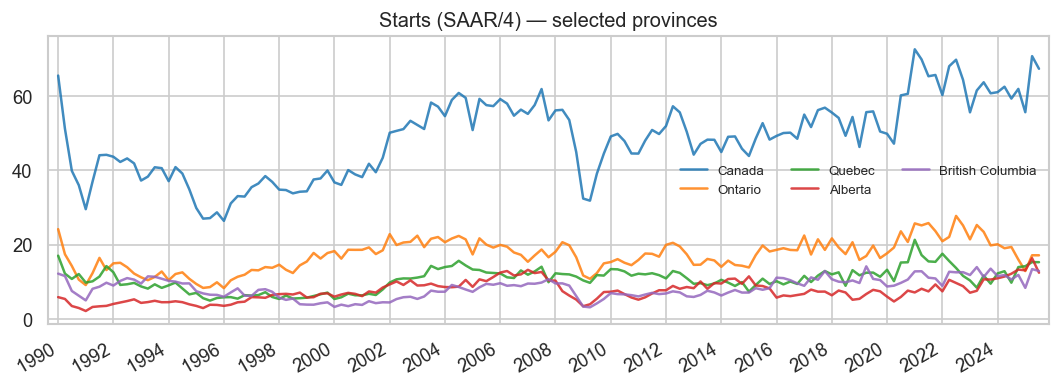

In [64]:
# %% [code]
def quick_overlay(df, col, provinces=None, title=None):
    provinces = provinces or PROVINCES_ORDER
    plt.figure(figsize=(9,3.4))
    for p in provinces:
        sub = df[df["province"]==p].sort_values("quarter")
        if sub.empty: continue
        plt.plot(_to_dt(sub["quarter"]), sub[col], alpha=0.85, lw=1.5, label=PROVINCE_NAMES.get(p,p))
    plt.title(title or col); plt.margins(x=0.01)
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    if len(provinces)<=6: plt.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

quick_overlay(df, "starts_saar_q", provinces=["can","on","qc","ab","bc"], title="Starts (SAAR/4) — selected provinces")


In [65]:
# %% [code]
def registry_models():
    models = {
        # Linear / robust
        "lr":       Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())]),
        "ridge":    Pipeline([("scaler", StandardScaler()), ("m", Ridge())]),
        "lasso":    Pipeline([("scaler", StandardScaler()), ("m", Lasso(max_iter=5000, random_state=RANDOM_STATE))]),
        "enet":     Pipeline([("scaler", StandardScaler()), ("m", ElasticNet(max_iter=5000, random_state=RANDOM_STATE))]),
        "huber":    Pipeline([("scaler", StandardScaler()), ("m", HuberRegressor(max_iter=5000))]),

        # Ensembles
        "rf":         RandomForestRegressor(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1),
        "extratrees": ExtraTreesRegressor(n_estimators=700, random_state=RANDOM_STATE, n_jobs=-1),
        "gbr":        GradientBoostingRegressor(n_estimators=800, learning_rate=0.03, max_depth=3, random_state=RANDOM_STATE),

        # Kernel / instance
        "svr":      Pipeline([("scaler", StandardScaler()), ("m", SVR())]),
        "knn":      Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor())]),
    }
    if HAS_XGB:
        models["xgb"] = XGBRegressor(
            n_estimators=1000, learning_rate=0.03, max_depth=5,
            subsample=0.8, colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_LGBM:
        models["lgbm"] = lgb.LGBMRegressor(
            n_estimators=1200, learning_rate=0.03, subsample=0.9,
            colsample_bytree=0.8, random_state=RANDOM_STATE, n_jobs=-1
        )
    if HAS_CAT:
        models["cat"] = CatBoostRegressor(
            depth=6, learning_rate=0.05, iterations=1200, random_seed=RANDOM_STATE, verbose=False, loss_function="MAE"
        )
    return models

def default_grids():
    grids = {
        # Linear family (pipeline step is "m__...")
        "ridge": {"m__alpha": np.logspace(-3,3,13)},
        "lasso": {"m__alpha": np.logspace(-4,1,12)},
        "enet":  {"m__alpha": np.logspace(-4,1,10), "m__l1_ratio": [0.2,0.5,0.8,1.0]},
        "huber": {"m__epsilon": [1.1, 1.35, 1.5], "m__alpha": [0.0, 0.0001, 0.001]},

        # Ensembles
        "rf":         {"n_estimators": [400,700,1000], "max_depth": [None, 8, 14], "min_samples_leaf": [1,2,4]},
        "extratrees": {"n_estimators": [500,800,1100], "max_depth": [None, 10, 16], "min_samples_leaf": [1,2,4]},
        "gbr":        {"n_estimators":[600,800,1200], "learning_rate":[0.02,0.03,0.05], "max_depth":[2,3]},

        # Kernel / instance-based
        "svr": {"m__C":[0.5,1,2,4], "m__epsilon":[0.05,0.1,0.2], "m__gamma":["scale","auto"]},
        "knn": {"m__n_neighbors":[3,5,7,9], "m__weights":["uniform","distance"]},
    }
    if HAS_XGB:
        grids["xgb"] = {"n_estimators":[800,1200,1600], "max_depth":[4,5,6], "learning_rate":[0.02,0.03,0.05], "subsample":[0.7,0.9]}
    if HAS_LGBM:
        grids["lgbm"] = {"n_estimators":[800,1200,1600], "num_leaves":[31,63,127], "learning_rate":[0.02,0.03]}
    if HAS_CAT:
        grids["cat"] = {"depth":[6,8], "iterations":[800,1200,1600], "learning_rate":[0.03,0.05]}
    return grids

def ts_cv(n_splits=5):  # expanding-window CV
    return TimeSeriesSplit(n_splits=n_splits)

def tune_model(estimator, param_grid, X, y, cv=None, scoring="neg_mean_absolute_error", n_jobs=-1, verbose=0):
    cv = cv or ts_cv()
    gs = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, n_jobs=n_jobs, verbose=verbose)
    gs.fit(X, y)
    return gs   # has .best_estimator_, .best_params_, .cv_results_


In [66]:
# %% [code]
# NEW/CHANGED: Parameter cache for tuned best params (JSON-based)
import json, hashlib

CACHE_FILE = "model_tuned_params_cache.json"  # NEW/CHANGED

def _load_cache(path=CACHE_FILE) -> Dict:
    if os.path.exists(path):
        try:
            with open(path, "r") as f:
                return json.load(f)
        except Exception:
            return {}
    return {}

def _save_cache(cache_dict: Dict, path=CACHE_FILE):
    with open(path, "w") as f:
        json.dump(cache_dict, f, indent=2)

PARAM_CACHE = _load_cache()  # NEW/CHANGED

def _feature_sig(feature_cols: List[str]) -> str:
    """Stable signature for a feature set (order-insensitive)."""
    joined = "|".join(sorted(feature_cols))
    return hashlib.md5(joined.encode("utf-8")).hexdigest()[:8]

def _cache_key(scope: str, model_name: str, split_point: str, feature_cols: List[str]) -> str:
    """
    scope: "pooled" OR province code, e.g., "on"
    """
    return f"{scope}::{model_name}::{split_point}::{_feature_sig(feature_cols)}"

def get_cached_or_tune(  # NEW/CHANGED
    model_name: str,
    scope: str,  # "pooled" or a province code
    est,
    grid: dict,
    X_tr,
    y_tr,
    feature_cols: List[str],
    split_point: str,
    scoring="neg_mean_absolute_error",
    force_retrain: bool = False
):
    """
    Try cache → else tune → save to cache.
    Returns: (fitted_estimator, best_params_dict, used_cache_bool)
    """
    key = _cache_key(scope, model_name, split_point, feature_cols)

    if (not force_retrain) and (key in PARAM_CACHE):
        best_params = PARAM_CACHE[key]
        # set params (works for Pipeline and bare estimators)
        try:
            est.set_params(**best_params)
        except Exception:
            # param mismatch (e.g., version change) → re-tune
            gs = tune_model(est, grid, X_tr, y_tr, scoring=scoring, n_jobs=-1, verbose=0)
            best_params = gs.best_params_
            PARAM_CACHE[key] = best_params
            _save_cache(PARAM_CACHE)
            return gs.best_estimator_, best_params, False
        est.fit(X_tr, y_tr)
        return est, best_params, True

    # need to tune
    gs = tune_model(est, grid, X_tr, y_tr, scoring=scoring, n_jobs=-1, verbose=0)
    best_params = gs.best_params_
    PARAM_CACHE[key] = best_params
    _save_cache(PARAM_CACHE)
    return gs.best_estimator_, best_params, False


In [67]:
# %% [code]
MODEL_COLORS = {
    "lr": "#1f77b4", "ridge": "#2ca02c", "lasso": "#17becf", "enet": "#ff7f0e", "huber": "#bcbd22",
    "rf": "#9467bd", "extratrees": "#7f7f7f", "gbr": "#8c564b",
    "svr": "#e377c2", "knn": "#d62728",
    "xgb": "#2b8cbe", "lgbm": "#41ab5d", "cat": "#fd8d3c"
}

def plot_scatter_actual_pred(y_true, y_pred, title="Actual vs Predicted"):
    lims = [np.nanmin([y_true.min(), y_pred.min()]), np.nanmax([y_true.max(), y_pred.max()])]
    plt.figure(figsize=(4.8,4.2))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot(lims, lims, 'k--', lw=1)
    plt.xlim(lims); plt.ylim(lims)
    plt.title(title + f"\nMAE={mae(y_true,y_pred):.3f}, RMSE={rmse(y_true,y_pred):.3f}, R²={r2_score(y_true,y_pred):.3f}")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout(); plt.show()

def plot_model_bars(metrics_df: pd.DataFrame, title="MASE by model"):
    fig, ax = plt.subplots(figsize=(9.5,4))
    tmp = metrics_df.copy()
    tmp["who"] = tmp.get("province", "pooled")
    sns.barplot(data=tmp, x="who", y="MASE", hue="model", ax=ax)
    ax.axhline(1.0, color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel(""); ax.set_ylabel("MASE (lower is better)")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def overlay_models_one_province(df_all, preds_store, province, models: List[str], title_suffix=""):
    if province not in preds_store:
        print(f"No preds for province {province}"); return
    first = next((preds_store[province][m] for m in models if m in preds_store[province]), None)
    if first is None:
        print("None of the requested models have predictions stored."); return

    tr_idx, te_idx = first["idx_tr"], first["idx_te"]
    tr = df_all.loc[tr_idx].sort_values("quarter")
    te = df_all.loc[te_idx].sort_values("quarter")
    x_tr = _to_dt(tr["quarter"]); y_tr = tr[TARGET].values
    x_te = _to_dt(te["quarter"]); y_te = te[TARGET].values

    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    # Actual in black
    ax.plot(x_tr, y_tr, color="black", lw=2, label="Actual (train)")
    ax.plot(x_te, y_te, color="black", lw=2, label="Actual (test)")

    for m in models:
        if m not in preds_store[province]: 
            continue
        rec = preds_store[province][m]
        # align prediction order to sorted indices we plotted above
        yhat_tr = rec["yhat_tr"][np.argsort(tr.index)]
        yhat_te = rec["yhat_te"][np.argsort(te.index)]
        color = MODEL_COLORS.get(m.split("(")[0], None)
        ax.plot(x_tr, yhat_tr, lw=1, color=color, label=f"{m} (train)")
        ax.plot(x_te, yhat_te, lw=1, ls="--", color=color, label=f"{m} (test)")

    ax.axvline(x_te.min(), color="gray", ls="--", lw=1, alpha=0.7)
    prov_name = PROVINCE_NAMES.get(province, province)
    ax.set_title(f"{prov_name} — Multi-model overlay {title_suffix}")
    ax.set_ylabel(TARGET + " (thousands/quarter)")
    ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()

def overlay_models_pooled(df_all, pooled_preds_store, models: List[str], title_suffix=""):
    if "pooled" not in pooled_preds_store:
        print("No pooled predictions"); return
    first_key = next((m for m in models if m in pooled_preds_store["pooled"]), None)
    if first_key is None:
        print("None of the requested pooled models found."); return

    base = pooled_preds_store["pooled"][first_key]
    te = df_all.loc[base["idx_te"]].copy().sort_values(["quarter"])
    # Actual national aggregate (test)
    nat_actual = te.groupby("quarter")[[TARGET]].sum().reset_index().sort_values("quarter")
    x = _to_dt(nat_actual["quarter"]); y_actual = nat_actual[TARGET].values

    plt.figure(figsize=(9,3.2))
    ax = plt.gca()
    ax.plot(x, y_actual, color="black", lw=2, label="Actual (test sum)")

    # models
    for m in models:
        if m not in pooled_preds_store["pooled"]: 
            continue
        rec = pooled_preds_store["pooled"][m]
        # test
        te_m = df_all.loc[rec["idx_te"]].copy()
        te_m["pred"] = rec["yhat_te"]
        nat_pred = te_m.groupby("quarter")[["pred"]].sum().reset_index().sort_values("quarter")
        ax.plot(_to_dt(nat_pred["quarter"]), nat_pred["pred"], lw=1, ls="--",
                color=MODEL_COLORS.get(m.split("(")[0], None), label=f"{m} (test)")
        # train
        tr_m = df_all.loc[rec["idx_tr"]].copy()
        tr_m["pred"] = rec["yhat_tr"]
        nat_pred_tr = tr_m.groupby("quarter")[["pred"]].sum().reset_index().sort_values("quarter")
        ax.plot(_to_dt(nat_pred_tr["quarter"]), nat_pred_tr["pred"], lw=1,
                color=MODEL_COLORS.get(m.split("(")[0], None), alpha=0.95, label=f"{m} (train)")

    split_ts = pd.Period(SPLIT_POINT, freq="Q").to_timestamp()
    ax.axvline(split_ts, color="gray", ls="--", lw=1, alpha=0.7)
    ax.set_title(f"Pooled — National aggregate — Multi-model overlay {title_suffix}")
    ax.set_ylabel(TARGET + " (thousands/quarter)")
    ax.margins(x=0.01)
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    for t in ax.get_xticklabels(): t.set_rotation(30); t.set_ha("right")
    ax.legend(ncol=3, fontsize=8, frameon=False)
    plt.tight_layout(); plt.show()


In [68]:
# %% [code]
def run_per_province(df_feat: pd.DataFrame, feature_cols: List[str], split_point=SPLIT_POINT,
                     do_tune=False, models_to_try=("ridge","gbr","rf","lr"),
                     force_retrain: bool = False,                   # NEW/CHANGED (optional)
                     score_metric: str = "neg_mean_absolute_error"  # NEW/CHANGED (optional)
                    ):
    reg_all = registry_models()
    grids   = default_grids()

    results = []
    preds_store = {}
    provinces = [p for p in PROVINCES_ORDER if p in df_feat["province"].unique()]

    for p in provinces:
        sub = df_feat[df_feat["province"]==p].dropna(subset=feature_cols+[TARGET]).copy()
        if sub.empty: continue
        tr, te = chrono_split(sub, split_point)
        if tr.empty or te.empty: continue

        X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
        X_te, y_te = te[feature_cols].values, te[TARGET].values

        for name in models_to_try:
            if name not in reg_all: continue
            est = reg_all[name]

            # NEW/CHANGED: cache-aware tuning
            if do_tune and name in grids:
                est, best_params, used_cache = get_cached_or_tune(
                    model_name=name, scope=p, est=est, grid=grids[name],
                    X_tr=X_tr, y_tr=y_tr, feature_cols=feature_cols,
                    split_point=split_point, scoring=score_metric,
                    force_retrain=force_retrain
                )
                name_key = f"{name}(cached)" if used_cache else f"{name}(tuned)"
            else:
                best_params = None
                name_key = name
                est.fit(X_tr, y_tr)

            yhat_tr = est.predict(X_tr)
            yhat_te = est.predict(X_te)

            results.append({
                "province": p,
                "model": name_key,
                "MAE": mae(y_te, yhat_te),
                "RMSE": rmse(y_te, yhat_te),
                "sMAPE(%)": smape(y_te, yhat_te)*100,
                "MASE": mase(y_te, yhat_te, y_train=y_tr, seasonality=4),
                "R2_test": r2_score(y_te, yhat_te),
                "params": best_params
            })

            preds_store.setdefault(p, {})[name_key] = {
                "idx_tr": tr.index, "idx_te": te.index,
                "y_tr": y_tr, "y_te": y_te,
                "yhat_tr": yhat_tr, "yhat_te": yhat_te
            }
    return pd.DataFrame(results).sort_values(["province","RMSE"]).reset_index(drop=True), preds_store

def run_pooled(df_feat: pd.DataFrame, feature_cols: List[str], split_point=SPLIT_POINT,
               do_tune=False, models_to_try=("ridge","gbr","rf","lr"),
               force_retrain: bool = False,                   # NEW/CHANGED (optional)
               score_metric: str = "neg_mean_absolute_error"  # NEW/CHANGED (optional)
              ):
    reg_all = registry_models()
    grids   = default_grids()

    use_cols = ["province","quarter",TARGET] + feature_cols
    data = df_feat.dropna(subset=use_cols).copy()
    tr, te = chrono_split(data, split_point)
    if tr.empty or te.empty: return pd.DataFrame(), {}

    X_tr, y_tr = tr[feature_cols].values, tr[TARGET].values
    X_te, y_te = te[feature_cols].values, te[TARGET].values

    results = []
    preds_store = {"pooled":{}}

    for name in models_to_try:
        if name not in reg_all: continue
        est = reg_all[name]

        # NEW/CHANGED: cache-aware tuning
        if do_tune and name in grids:
            est, best_params, used_cache = get_cached_or_tune(
                model_name=name, scope="pooled", est=est, grid=grids[name],
                X_tr=X_tr, y_tr=y_tr, feature_cols=feature_cols,
                split_point=split_point, scoring=score_metric,
                force_retrain=force_retrain
            )
            name_key = f"{name}(cached)" if used_cache else f"{name}(tuned)"
        else:
            best_params = None
            name_key = name
            est.fit(X_tr, y_tr)

        yhat_tr = est.predict(X_tr)
        yhat_te = est.predict(X_te)

        results.append({
            "province":"pooled",
            "model": name_key,
            "MAE": mae(y_te, yhat_te),
            "RMSE": rmse(y_te, yhat_te),
            "sMAPE(%)": smape(y_te, yhat_te)*100,
            "MASE": mase(y_te, yhat_te, y_train=y_tr, seasonality=4),
            "R2_test": r2_score(y_te, yhat_te),
            "params": best_params
        })

        preds_store["pooled"][name_key] = {
            "idx_tr": tr.index, "idx_te": te.index,
            "y_tr": y_tr, "y_te": y_te,
            "yhat_tr": yhat_tr, "yhat_te": yhat_te
        }
    return pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True), preds_store


In [69]:
# %% [code]
models_big = (
    "ridge","lasso","enet","huber","rf","extratrees","gbr","svr","knn","lr"
) + (("xgb",) if HAS_XGB else ()) + (("lgbm",) if HAS_LGBM else ()) + (("cat",) if HAS_CAT else ())

# Per-province (first run tunes & caches; later runs reuse)
per_metrics, per_preds = run_per_province(
    df_feat, BASE_FEATS, do_tune=True, models_to_try=models_big,
    force_retrain=False,                   # set True to ignore cache
    score_metric="neg_mean_absolute_error" # tuning objective
)
display(per_metrics.head(20))

# Pooled
pool_metrics, pool_preds = run_pooled(
    df_feat, POOLED_FEATS, do_tune=True, models_to_try=models_big,
    force_retrain=False,                   # set True to ignore cache
    score_metric="neg_mean_absolute_error"
)
display(pool_metrics.head(20))


,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,ab,enet(tuned),1.343771,1.611463,15.176867,0.928141,0.663660,"{'m__alpha': 0.05994842503189409, 'm__l1_ratio..."
1,ab,lasso(tuned),1.360901,1.622148,15.374167,0.939973,0.659185,{'m__alpha': 0.05336699231206307}
2,ab,extratrees(tuned),1.442781,1.768755,15.703467,0.996528,0.594797,"{'max_depth': None, 'min_samples_leaf': 4, 'n_..."
3,ab,ridge(tuned),1.570352,1.785428,17.380484,1.084641,0.587121,{'m__alpha': 0.001}
4,ab,lr,1.570350,1.785435,17.380491,1.084640,0.587118,None
5,ab,rf(tuned),1.525924,1.906517,17.057423,1.053954,0.529219,"{'max_depth': 8, 'min_samples_leaf': 1, 'n_est..."
6,ab,huber(tuned),1.767507,1.962890,18.909512,1.220816,0.500967,"{'m__alpha': 0.0, 'm__epsilon': 1.1}"
7,ab,xgb(tuned),1.634917,2.040050,17.681250,1.129236,0.460962,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est..."
8,ab,cat(tuned),1.650365,2.044886,17.806081,1.139906,0.458403,"{'depth': 6, 'iterations': 1200, 'learning_rat..."
9,ab,knn(tuned),1.641997,2.057381,17.612415,1.134126,0.451764,"{'m__n_neighbors': 3, 'm__weights': 'distance'}"


,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,pooled,lr,1.209836,2.247216,20.255503,0.789072,0.983759,None
1,pooled,ridge(tuned),1.210445,2.251545,20.476677,0.789469,0.983697,{'m__alpha': 0.1}
2,pooled,enet(tuned),1.217300,2.268238,21.059979,0.793940,0.983454,"{'m__alpha': 0.016681005372000592, 'm__l1_rati..."
3,pooled,lasso(tuned),1.219503,2.274390,21.123042,0.795376,0.983364,{'m__alpha': 0.01873817422860383}
4,pooled,huber(tuned),1.233339,2.325449,20.267473,0.804401,0.982609,"{'m__alpha': 0.001, 'm__epsilon': 1.5}"
5,pooled,rf(tuned),1.715719,3.522665,20.729775,1.119015,0.960093,"{'max_depth': None, 'min_samples_leaf': 2, 'n_..."
6,pooled,extratrees(tuned),1.820538,3.790731,21.763963,1.187380,0.953788,"{'max_depth': None, 'min_samples_leaf': 2, 'n_..."
7,pooled,xgb(tuned),1.999907,4.167567,21.707447,1.304367,0.944143,"{'learning_rate': 0.03, 'max_depth': 4, 'n_est..."
8,pooled,gbr(tuned),2.104102,4.458176,22.601360,1.372324,0.936082,"{'learning_rate': 0.02, 'max_depth': 3, 'n_est..."
9,pooled,cat(tuned),2.518101,5.429190,25.515952,1.642340,0.905206,"{'depth': 6, 'iterations': 1600, 'learning_rat..."


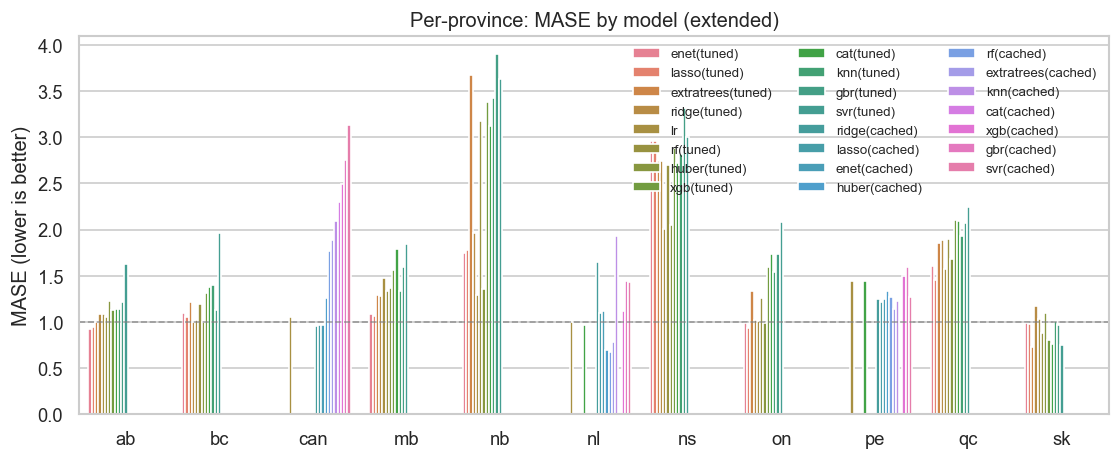

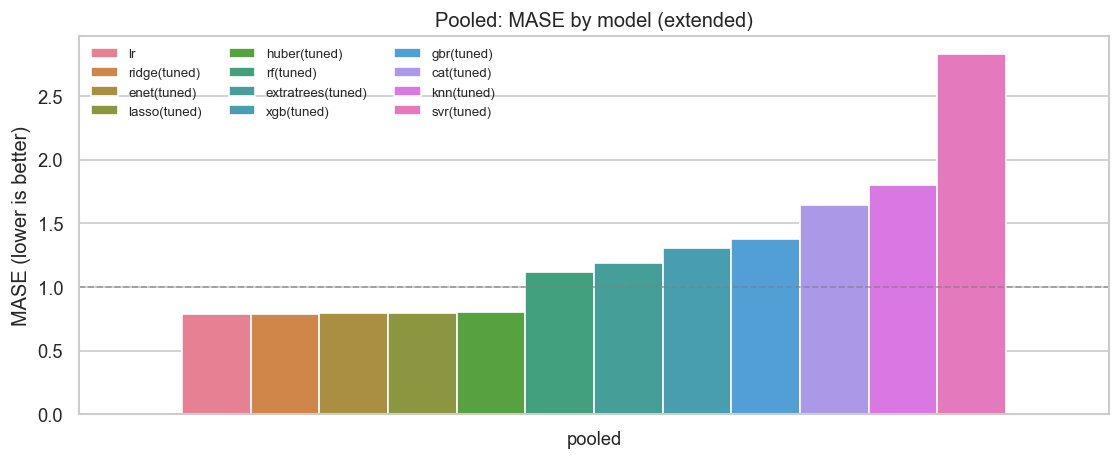

,province,model,RMSE,MAE,MASE,R2_test
0,ab,enet(tuned),1.611463,1.343771,0.928141,0.663660
12,bc,ridge(tuned),1.717102,1.377586,1.002430,-0.136799
24,can,lr,5.847527,5.151608,1.054609,0.101709
36,mb,lasso(tuned),0.332172,0.246597,1.063851,-0.334986
48,nb,lr,0.253859,0.207987,1.287566,0.662484
60,nl,rf(cached),0.104868,0.089770,0.668401,-0.023967
72,ns,lr,0.584047,0.442021,2.002872,0.092816
84,on,lr,2.873398,2.384183,1.006399,0.383580
96,pe,lasso(cached),0.100516,0.070696,1.220050,0.000566
108,qc,lasso(tuned),2.668039,2.128599,1.451551,0.186515


,province,model,MAE,RMSE,sMAPE(%),MASE,R2_test,params
0,pooled,lr,1.209836,2.247216,20.255503,0.789072,0.983759,None


In [70]:
# %% [code]
plot_model_bars(per_metrics, title="Per-province: MASE by model (extended)")
plot_model_bars(pool_metrics.assign(province="pooled"), title="Pooled: MASE by model (extended)")

best_per = (
    per_metrics.sort_values(["province","RMSE"])
    .groupby("province").head(1)[["province","model","RMSE","MAE","MASE","R2_test"]]
)
display(best_per)

best_pooled = pool_metrics.sort_values("RMSE").head(1)
display(best_pooled)


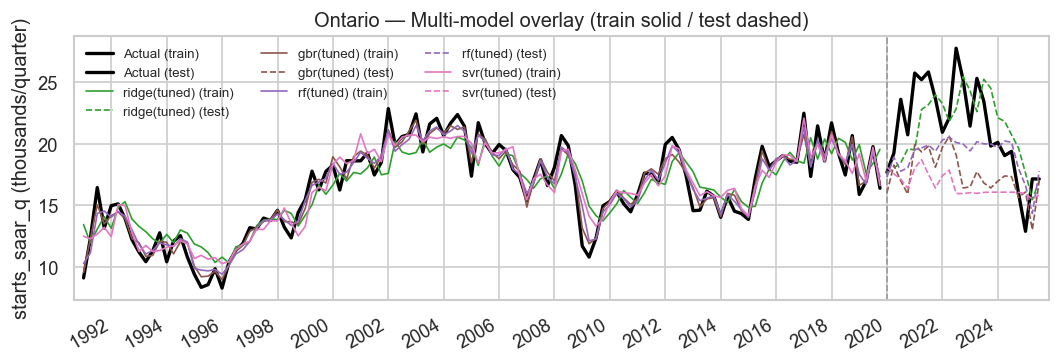

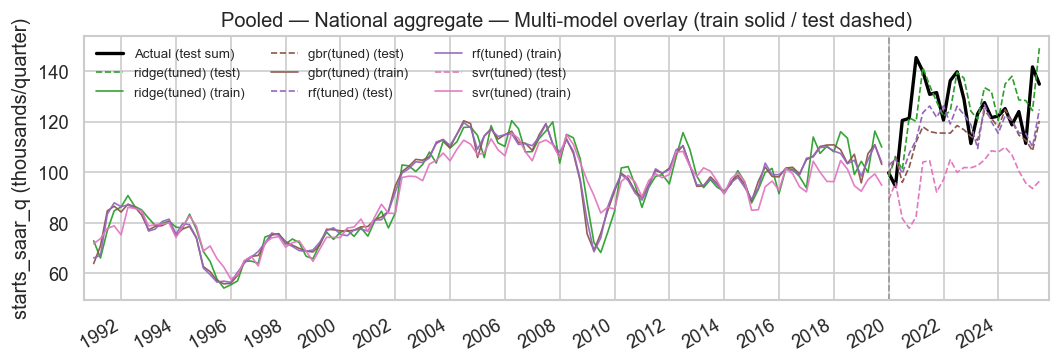

In [71]:
# %% [code]
# Example province overlay
overlay_models_one_province(
    df_feat, per_preds, province="on",
    models=["ridge(tuned)","gbr(tuned)","rf(tuned)","svr(tuned)"],
    title_suffix="(train solid / test dashed)"
)

# Example pooled overlay (national aggregate)
overlay_models_pooled(
    df_feat, pool_preds,
    models=["ridge(tuned)","gbr(tuned)","rf(tuned)","svr(tuned)"],
    title_suffix="(train solid / test dashed)"
)
